In [63]:
!pip install vaderSentiment
!pip install scikit-surprise
!pip install folium
!pip install surprise

In [64]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings

# sklearn ML tools
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split as sklearn_train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Advanced ML
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Recommendation system
#from surprise import Reader, Dataset, SVD, accuracy, BaselineOnly, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

# Utilities
import joblib
import random

# Plotting config
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Load in our Encoded and aggregated Data set**

In [65]:
dublin_encoded_df = pd.read_csv('dublin_encoded_df.csv')
dublin_encoded_df.head(2)

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood_cleansed_freq,property_type_freq
0,44077,193005,1.0,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,0.13507,0.006663
1,85156,193005,1.0,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,0.13507,0.006663


In [66]:
dublin_aggregated_df = pd.read_csv('dublin_aggregated_df.csv')
dublin_aggregated_df.head(2)

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood_cleansed,property_type,neighbourhood_cleansed_freq,property_type_freq
0,44077,193005,1.0,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,Dn Laoghaire-Rathdown,Private room in bungalow,0.13507,0.006663
1,85156,193005,1.0,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,Dn Laoghaire-Rathdown,Private room in bungalow,0.13507,0.006663


The features (X) were extracted by removing the id_x and price columns from the preprocessed dataset dublin_encoded_df. The price column was separately stored as the target variable (y). having seen the skweness of our target variable price, A natural logarithmic transformation was applied to the price variable to reduce its right skewness. This transformation is to stabilize variance and improve the performance of regression models that assume normally distributed residuals and improve model performance

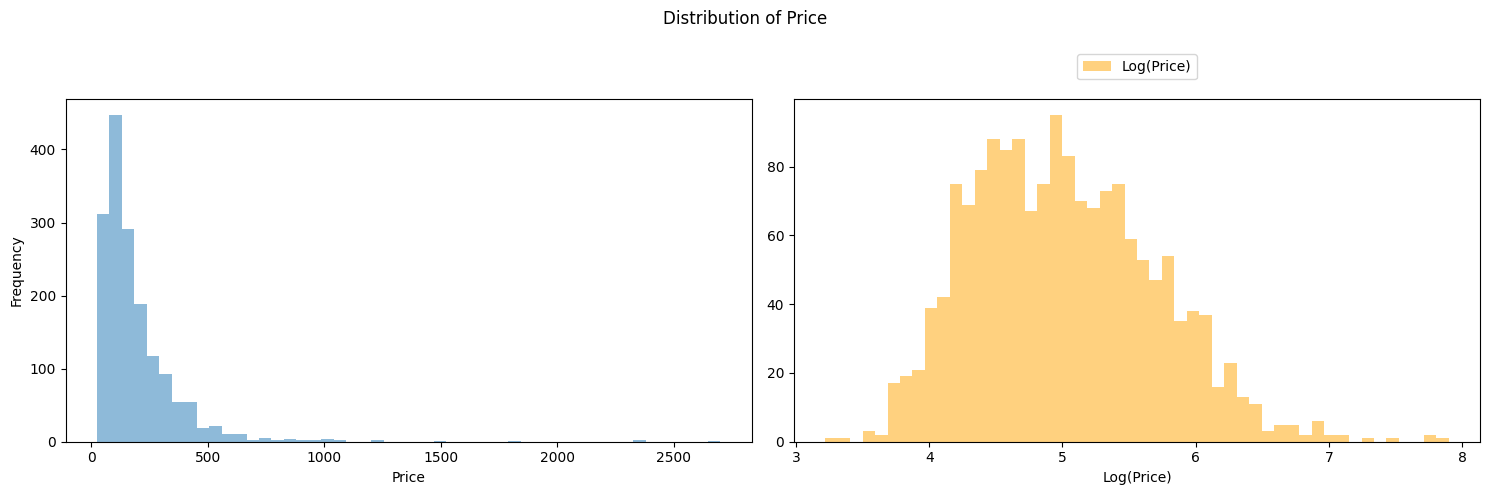

In [67]:
# split data
X = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y = dublin_encoded_df['price']

# log transform y variable(price)
y_log = np.log(y)
y_log.name = "log(price)"

# plot the raw y variable and log transformed y variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # figure with 2 subplots

# Plot original price distribution
ax[0].hist(y, bins=50, alpha=0.5, label="Price")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")

# Plot log-transformed price distribution
ax[1].hist(y_log, bins=50, color="orange", alpha=0.5, label="Log(Price)")
ax[1].set_xlabel("Log(Price)")

# Add legend
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

# main title
plt.suptitle("Distribution of Price")

plt.tight_layout()
plt.show()

In [68]:
#LOG transform target variable price.
X_log = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y_log = np.log(dublin_encoded_df['price'])

In [69]:
# Split data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = sklearn_train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In order to evaluate the performance of predictive models reliably, the dataset was divided into separate training and testing subsets. This ensures that model performance is assessed on unseen data, helping to prevent overfitting. X_log: The feature set (predictor variables) prepared for modeling, likely with the same dimensions as X but possibly preprocessed. y_log: The target variable (price) after log transformation. test_size=0.2, this Specifies 20% of the data was reserved for testing, and the remaining 80% used for training. random_state=42: Sets a fixed seed for the random number generator to ensure reproducibility of results. Using a fixed seed guarantees that the data split remains consistent across multiple runs. X_train_log and y_train_log: Used to train the model. X_test_log and y_test_log: Held out and used to evaluate the model's performance on unseen data. The reason for this split is such that it allows for allows for a robust assessment of how well our model generalizes. By training on one portion of the data and evaluating on another, we can better estimate real-world performance and reduce the likelihood of overfitting to our training data.


## Modeling
- Regression Models - for price prediction
- Collaborative-Filtering Models - for personalized airbnb recommendation
1. Regression Models We'll create various models for this project. We'll use a Linear Regression Model as the baseline. We'll also build a Decision Tree, Random Forest, KNN, Polynomial Regresssion, XGBoost and LightGBM . RMSE will be our evaluation metric.

**Baseline Model: Linear Regressio**n

**Pipeline Setup**

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

model_log_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

**Fit + Evaluate Log Model**

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def fit_log_results(pipe, X_train, X_test, y_train, y_test):
    """
    Fits pipeline on log-transformed target and returns metrics in log scale
    """
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Log-scale RMSE
    train_rmse = mean_squared_error(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)

    # MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # R2
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train RMSE (log-scale): {train_rmse:.4f}")
    print(f"Test RMSE (log-scale): {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("------------------------------------")

**Cross-Validation Evaluation**

In [72]:
from sklearn.model_selection import cross_val_predict

def cross_validate_log_results(pipe, X, y, cv=5):
    """
    Performs cross-validation and returns log-scale metrics
    """
    y_pred = cross_val_predict(pipe, X, y, cv=cv)

    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"Cross-validated RMSE (log-scale): {rmse:.4f}")
    print(f"Cross-validated MAE: {mae:.4f}")
    print(f"Cross-validated R² Score: {r2:.4f}")
    print("------------------------------------")

In [73]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def learn_curves(pipe, X, y, cv=5):
    """
    Generates learning curves in log-scale MSE
    """
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Error')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error (log-scale)')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

**Run Everything**

Train RMSE (log-scale): 0.1921
Test RMSE (log-scale): 0.1936
Train MAE: 0.3223, Test MAE: 0.3461
R² Score: 0.6016
------------------------------------
Cross-validated RMSE (log-scale): 0.1981
Cross-validated MAE: 0.3305
Cross-validated R² Score: 0.5794
------------------------------------


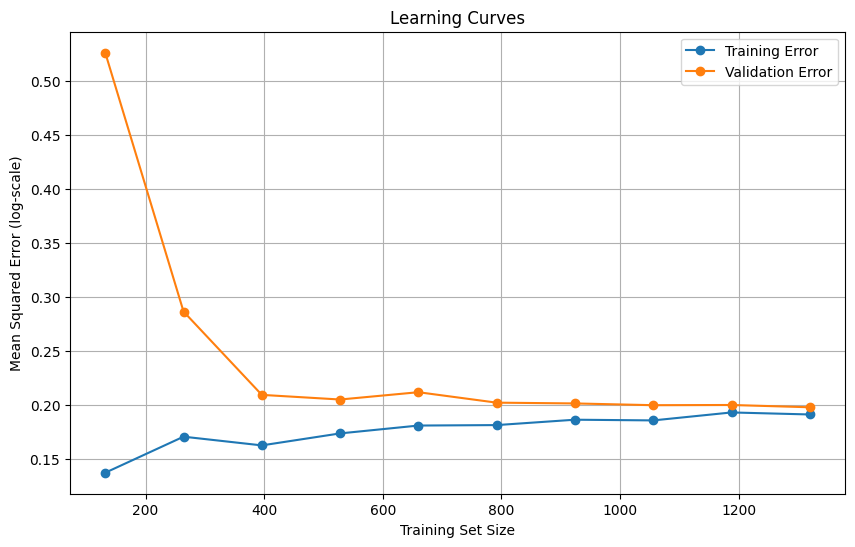

In [74]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit & evaluate
fit_log_results(model_log_pipeline, X_train_log, X_test_log, y_train_log, y_test_log)

# Cross-validated scores
cross_validate_log_results(model_log_pipeline, X_log, y_log, cv=kf)

# Plot learning curves
learn_curves(model_log_pipeline, X_log, y_log, cv=kf)

**Feature Importance Linear Regression**

                        Feature  Coefficient
4                  accommodates     0.517560
10  neighbourhood_cleansed_freq     0.113381
7                          beds    -0.074181
6                      bedrooms     0.060089
8                    avg_rating     0.034906
0                       host_id     0.030678
11           property_type_freq    -0.027363
1            host_response_rate    -0.017082
2             host_is_superhost     0.016809
3           host_listings_count     0.015495


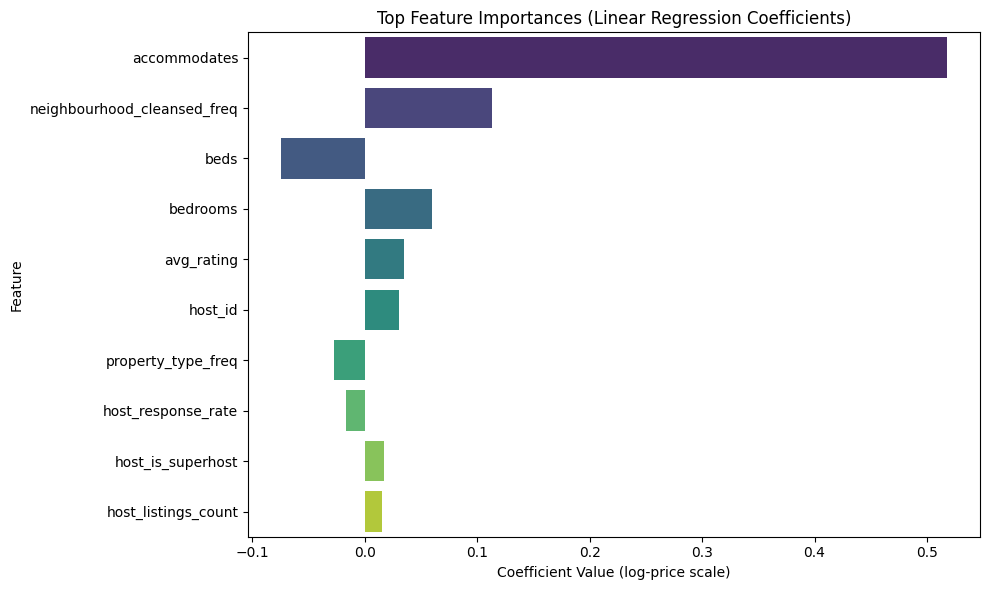

In [75]:
# Get the trained model
model_log_pipeline.fit(X_train_log, y_train_log)

# Extract coefficients from linear regression step
coefs = model_log_pipeline.named_steps['linreg'].coef_

# Match with feature names
feature_names = X_log.columns  # These should already be encoded features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top N
print(coef_df.head(10))

top_n = 10  # Show top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(top_n),
    y='Feature', x='Coefficient', palette='viridis'
)
plt.title('Top Feature Importances (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value (log-price scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The Linear Regression model shows to perform reasonably well because we can see that the Training vs. Test RMSE (log-scale): 0.1921 vs. 0.1936 looks very close, indicating low overfitting. While the MAE: 0.32 (train) vs. 0.35 (test) shows small error, suggesting good average prediction accuracy. R² Score: 0.60 the model explains around 60% of the variance in the data.

Cross-validation results are consistent with test performance, implying reliable generalization. For use to see further gains we try other more complex models.

*Feature interpretation*

accommodates is the most influential predictor in the model. Its large positive coefficient suggests that listings that accommodate more guests are strongly associated with higher prices. This aligns with intuitive expectations: larger listings can host more people and thus command higher prices.
neighbourhood_cleansed_freq, which likely represents the frequency or popularity of a neighbourhood, is also positively correlated with price. This indicates that listings in more frequently occurring or popular neighborhoods tend to be priced higher. beds and bedrooms show smaller positive effects. This suggests that the number of beds and bedrooms does influence pricing, but less so than the overall capacity (accommodates). Features like avg_rating, host_id, and property_type_freq have minor but positive coefficients, indicating weaker associations with price.

Interestingly, host_response_rate, host_is_superhost, and host_listings_count contribute only marginally to the prediction of price. This implies that host-specific attributes, although potentially important for customer satisfaction or booking likelihood, may not significantly influence the base listing price.

**Linear Regression (with PCA)**

Next, we reduce the dimensionality of the data using PCA to retain the most important features, simplifying the model while preserving essential information.

Train RMSE (log-scale): 0.2239
Test RMSE (log-scale): 0.2971
Train MAE: 0.3552, Test MAE: 0.3914
R² Score: 0.3887
------------------------------------
Cross-validated RMSE (log-scale): 0.2452
Cross-validated MAE: 0.3658
Cross-validated R² Score: 0.4794
------------------------------------


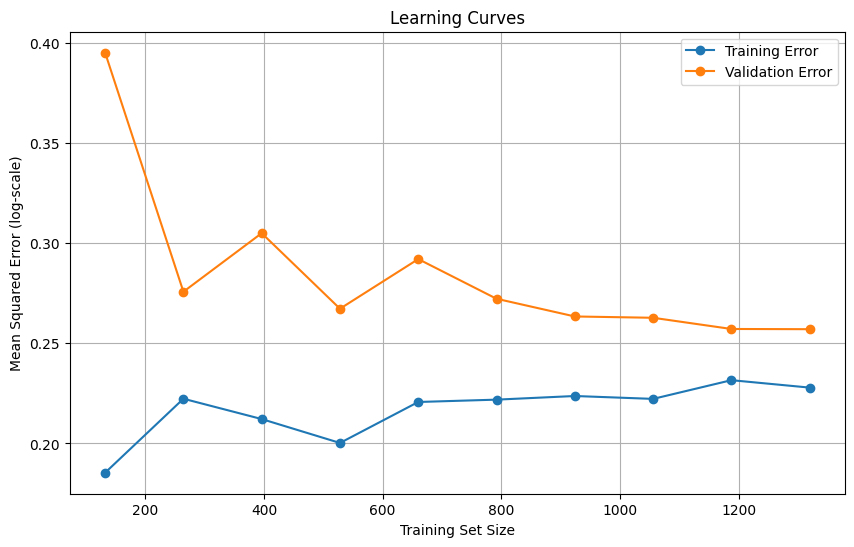

In [76]:
# pipeline including scaling and PCA
baseline_model_pca_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=9)), # pca
    ('linreg', LinearRegression()) # linear regression model
])

# Fit and evaluate the model
fit_log_results(baseline_model_pca_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(baseline_model_pca_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(baseline_model_pca_log, X_log, y_log)

**Feature importance Linear Regression (with PCA)**

                        Feature  Coefficient
4                  accommodates     0.517560
10  neighbourhood_cleansed_freq     0.113381
7                          beds    -0.074181
6                      bedrooms     0.060089
8                    avg_rating     0.034906
0                       host_id     0.030678
11           property_type_freq    -0.027363
1            host_response_rate    -0.017082
2             host_is_superhost     0.016809
3           host_listings_count     0.015495


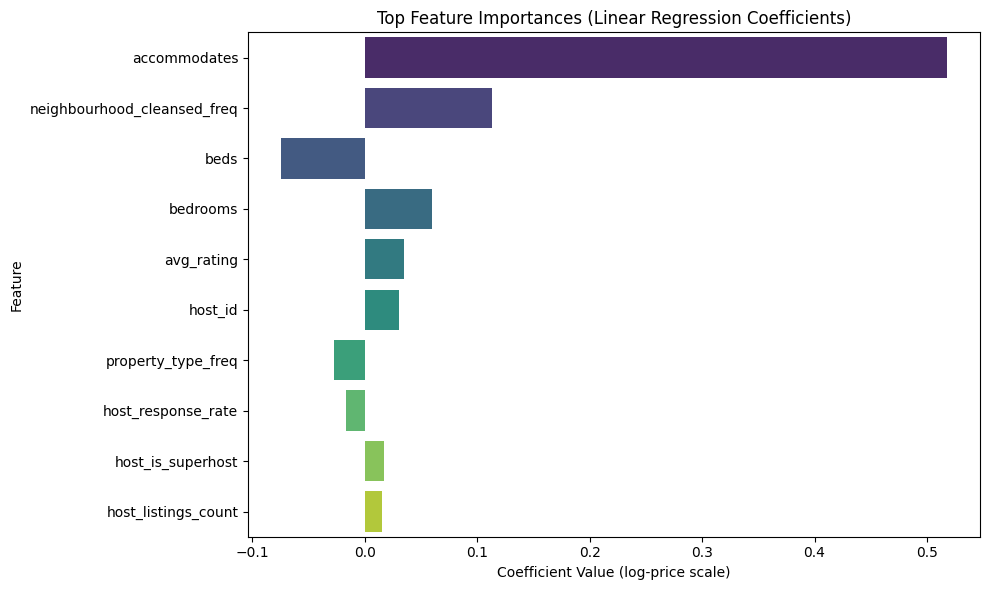

In [77]:
# Get the trained model
baseline_model_pca_log.fit(X_train_log, y_train_log)

# Extract coefficients from linear regression step
coefs = model_log_pipeline.named_steps['linreg'].coef_

# Match with feature names
feature_names = X_log.columns  # These should already be encoded features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top N
print(coef_df.head(10))

top_n = 10  # Show top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(top_n),
    y='Feature', x='Coefficient', palette='viridis'
)
plt.title('Top Feature Importances (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value (log-price scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This Linear Regression with PCA model ends up performming worse than the standard linear regression because there are Higher errors in the Train RMSE: 0.2239 looking higher than before and Test RMSE: 0.2971 shows worse generalization, Lower R² Score: 0.39 as agaisnt the previous LR 0.60. The LR with PCA model explains less variance. Cross-validation confirms poorer performance: lower R² and higher error metrics. PCA reduced model performance due to information loss in dimensionality reduction.

Feature Importance

The most influential feature is accommodates, indicating that listings hosting more guests tend to have significantly higher prices. neighbourhood_cleansed_freq also shows a strong positive effect, suggesting that location popularity impacts pricing. Room attributes such as bedrooms and beds contribute positively, though beds has a slight negative coefficient—likely due to multicollinearity. Minor positive influences come from avg_rating, property_type_freq, and host_id, while host-specific features like host_response_rate, host_is_superhost, and host_listings_count have minimal effect. As the model uses log-transformed price, coefficients can be interpreted multiplicatively (e.g., a coefficient of 0.5 ≈ 65% price increase). PCA helped reduce noise and multicollinearity, though original feature names were preserved, likely through selective dimensionality reduction.

**Decision Tree Model**

Train RMSE (log-scale): 0.1381
Test RMSE (log-scale): 0.1725
Train MAE: 0.2798, Test MAE: 0.3182
R² Score: 0.6451
------------------------------------
Cross-validated RMSE (log-scale): 0.1841
Cross-validated MAE: 0.3168
Cross-validated R² Score: 0.6091
------------------------------------


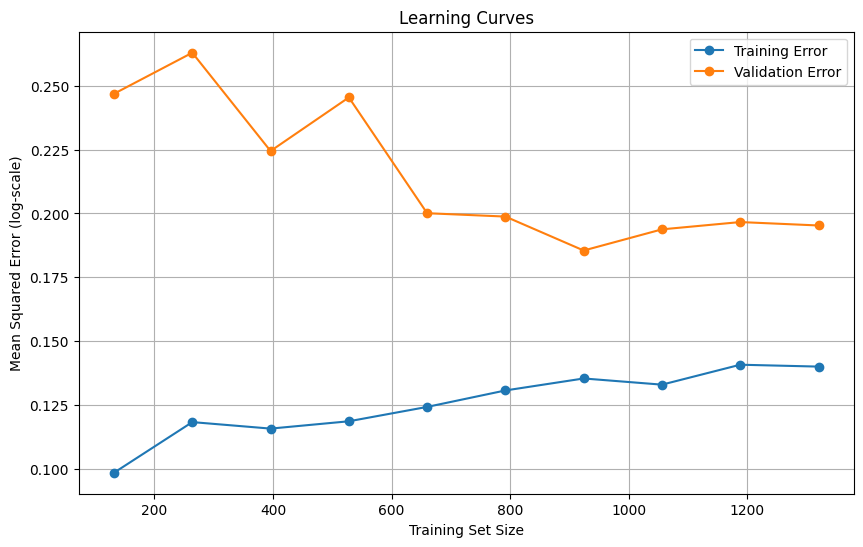

In [78]:
dt_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('dt', DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42))
])

# Fit and evaluate the model
fit_log_results(dt_model_log, X_train_log, X_test_log, y_train_log, y_test_log)

# Call the function to cross-validate the pipeline
cross_validate_log_results(dt_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(dt_model_log, X_log, y_log)

**Feature importance of Decision Tree Model**

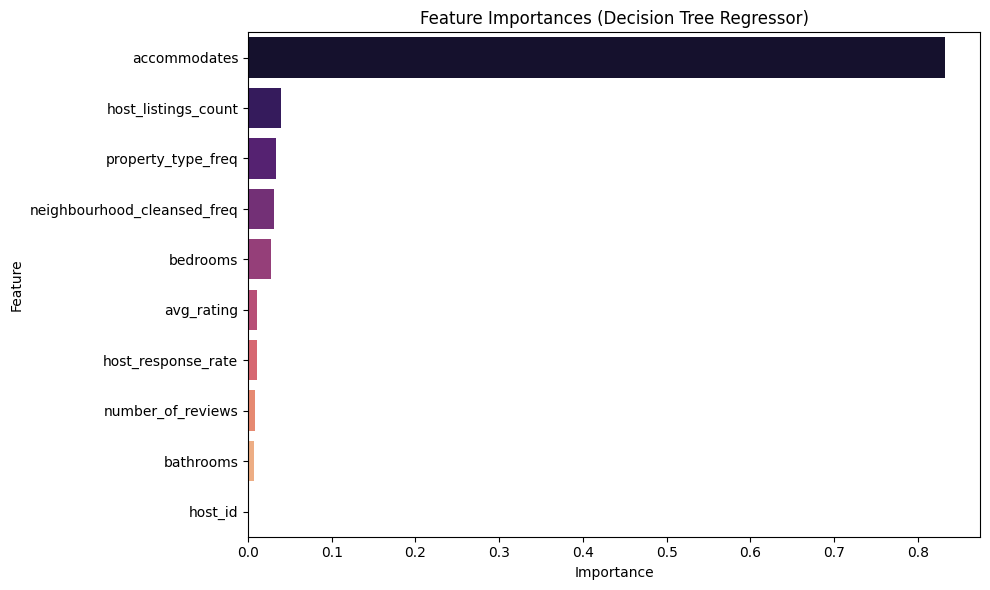

In [79]:
dt_model_log.fit(X_train_log, y_train_log)

# Get feature importances from the decision tree
importances = dt_model_log.named_steps['dt'].feature_importances_
feature_names = X_log.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top N features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='magma')
plt.title('Feature Importances (Decision Tree Regressor)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


This Decision Tree model shows Lower errors than linear models between the Train RMSE: 0.1381 (better fit) and Test RMSE: 0.1725 (better generalization) Higher R² Score: 0.6451 on test, indicating it explains 64.5% of variance, better than linear regression Cross-validation confirms strong performance, RMSE and R² are consistent, indicating stable results Although we there is a Learning curve gap between train and validation errors suggests some overfitting, but still generalizes well. Decision Tree performs well with good accuracy and reasonable generalization, better than the linear models here.

Feature Importance for decision tree model

In this model, accommodates dominates the predictions, accounting for over 80% of the total importance. This indicates that the number of people a listing can accommodate is the most critical factor influencing price. Other features with smaller but notable contributions include host_listings_count, property_type_freq, and neighbourhood_cleansed_freq, reflecting host experience, property type, and location popularity. Features such as avg_rating, number_of_reviews, and bathrooms had minimal impact on pricing decisions.

**Random Forest Model**

Train RMSE (log-scale): 0.0198
Test RMSE (log-scale): 0.1370
Train MAE: 0.0986, Test MAE: 0.2749
R² Score: 0.7181
------------------------------------
Cross-validated RMSE (log-scale): 0.1391
Cross-validated MAE: 0.2647
Cross-validated R² Score: 0.7046
------------------------------------


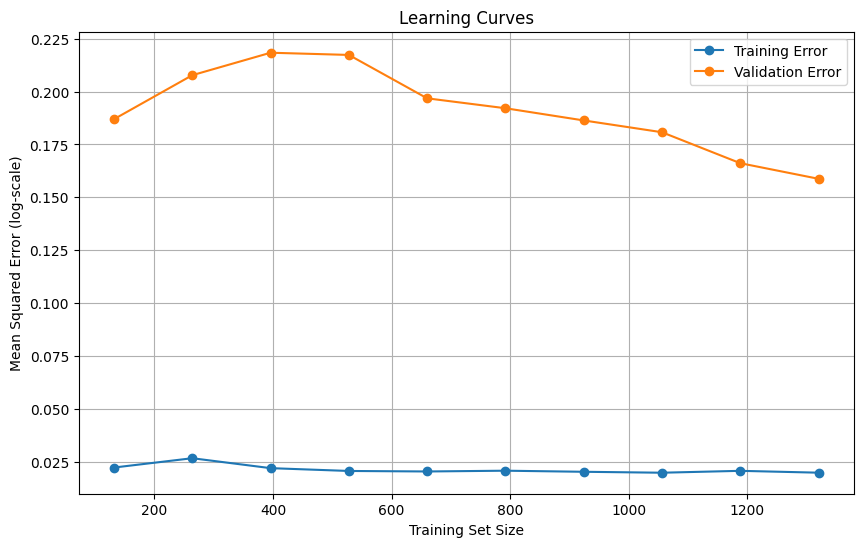

In [80]:
rf_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('rf', RandomForestRegressor(random_state=42))
])

# Fit and evaluate the model
fit_log_results(rf_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(rf_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(rf_model_log, X_log, y_log)

                        Feature  Importance
4                  accommodates    0.576671
8                    avg_rating    0.068357
0                       host_id    0.057246
11           property_type_freq    0.055390
9             number_of_reviews    0.052890
3           host_listings_count    0.047977
6                      bedrooms    0.045594
10  neighbourhood_cleansed_freq    0.027528
5                     bathrooms    0.024575
1            host_response_rate    0.021732


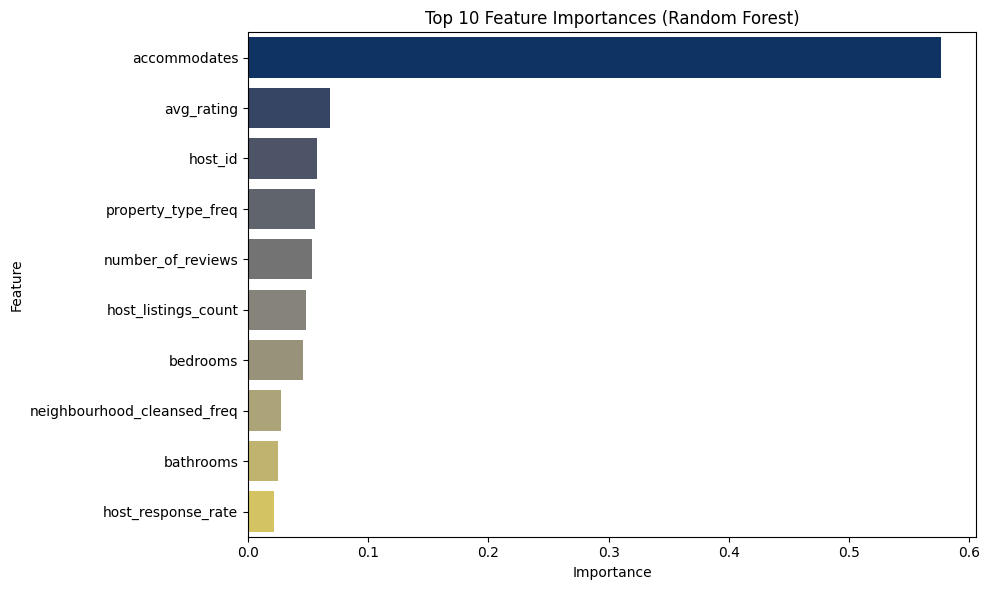

In [81]:
rf_model_log.fit(X_train_log, y_train_log)


# Get the trained Random Forest model
rf = rf_model_log.named_steps['rf']

# Extract feature importances and match them to feature names
importances = rf.feature_importances_
feature_names = X_log.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10
print(importance_df.head(10))

# Plot top 10 features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='cividis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


This Random Forest model shows Very low training error (RMSE 0.0198), indicating excellent fit on training data. Test error is higher but still low (RMSE 0.1370), showing good generalization. High R² score (0.7181) on test set, explaining about 72% of variance. Cross-validation results confirm stability and strong performance (R² = 0.70). The gap between training and validation error suggests some overfitting but controlled. Random Forest outperforms previous models with high accuracy and robust generalization.

*Feature importance for random Forest Model*

accommodates is the most significant feature by a large margin, accounting for more than half of the total importance. This suggests that the number of guests a listing can host is the most critical factor influencing price. Other features, such as avg_rating, host_id, and property_type_freq, also contribute but with considerably lower importance scores. number_of_reviews, host_listings_count, and bedrooms provide moderate predictive power, while features like neighbourhood_cleansed_freq, bathrooms, and host_response_rate show minimal impact. Random Forests compute feature importance based on the average decrease in impurity (Gini or MSE) across all trees, making the results more robust and generalizable than single decision trees. This analysis helps highlight which variables most influence pricing and supports informed feature selection.

**KNN Regression Model**

In [82]:
# model pipeline
knn_model_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=10)),
    ('knn', KNeighborsRegressor(n_neighbors=13, metric='euclidean'))
])

Train RMSE (log-scale): 0.1749
Test RMSE (log-scale): 0.2132
Train MAE: 0.3093, Test MAE: 0.3477
R² Score: 0.5613
------------------------------------
Cross-validated RMSE (log-scale): 0.2080
Cross-validated MAE: 0.3414
Cross-validated R² Score: 0.5583
------------------------------------


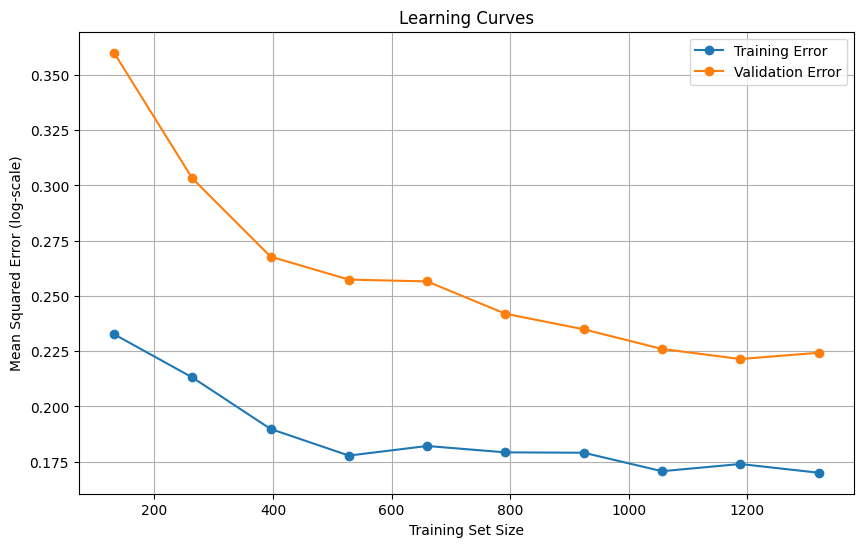

In [83]:
# Fit and evaluate the model
fit_log_results(knn_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# Cross-validate the pipeline
cross_validate_log_results(knn_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(knn_model_log, X_log, y_log)

This KNN Regression model shows Moderate training error (RMSE 0.1749) and higher test error (RMSE 0.2132), indicating some overfitting. Test R² score of 0.5613 means it explains about 56% of the variance which is quite low. Cross-validation results are consistent, confirming moderate predictive performance. Errors (MAE) are higher compared to Random Forest and Decision Tree models. KNN performs reasonably but less accurate and less generalizable than Random Forest or Decision Tree.

**Tuned KNN Regression Model (with Grid Search)**

In [84]:
from sklearn.model_selection import GridSearchCV
# parameter grid
param_grid = {
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__metric': ['euclidean', 'manhatt/an', 'minkowski']  # Corrected 'knn_metric' to 'knn__metric'
}

# GridSearchCV object
grid_search = GridSearchCV(knn_model_log, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_log, y_train_log)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 10}
Best score:  -0.20705561910426856


In [85]:
# Create the final model using the best parameters
knn_model_gs_log = Pipeline([
    ('scaler', StandardScaler()), # Standardizes the data
    ('pca', PCA(n_components=10)), # pca
    ('knn', KNeighborsRegressor(n_neighbors=grid_search.best_params_['knn__n_neighbors'],
                                 metric=grid_search.best_params_['knn__metric']))  # Uses best parameters
])

Train RMSE (log-scale): 0.1639
Test RMSE (log-scale): 0.2078
Train MAE: 0.2991, Test MAE: 0.3422
R² Score: 0.5726
------------------------------------
Cross-validated RMSE (log-scale): 0.2049
Cross-validated MAE: 0.3375
Cross-validated R² Score: 0.5649
------------------------------------


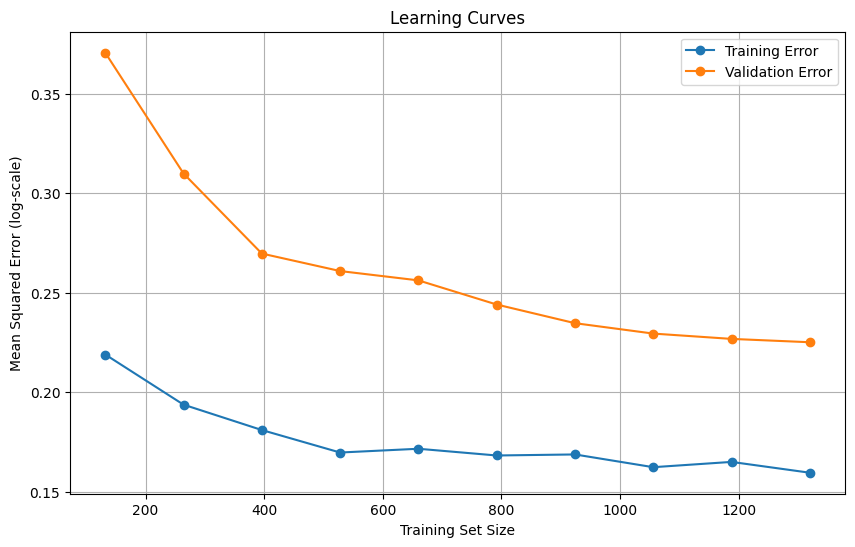

In [86]:
# Fit and evaluate the final model
fit_log_results(knn_model_gs_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(knn_model_gs_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(knn_model_gs_log, X_log, y_log)

This KNN Regression with Grid Search shows Best hyperparameters: 10 neighbors, Euclidean distance. Training RMSE (0.1639) and Test RMSE (0.2078) are close, indicating reduced overfitting. R² of 0.5726 suggests moderate explanatory power. Cross-validation metrics confirm consistent performance. Slight improvement over previous KNN model without tuning. Hyperparameter tuning improved KNN's stability and performance moderately.

**Polynomial Regression Model**

In [87]:
from sklearn.preprocessing import PolynomialFeatures
poly_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Creates polynomial features
    ('scaler', StandardScaler()),  # Standardizes the data
    ('linreg', LinearRegression())  # Fits linear regression on polynomial features
])

Train RMSE (log-scale): 0.1419
Test RMSE (log-scale): 0.2394
Train MAE: 0.2798, Test MAE: 0.3412
R² Score: 0.5074
------------------------------------
Cross-validated RMSE (log-scale): 0.2680
Cross-validated MAE: 0.3214
Cross-validated R² Score: 0.4309
------------------------------------


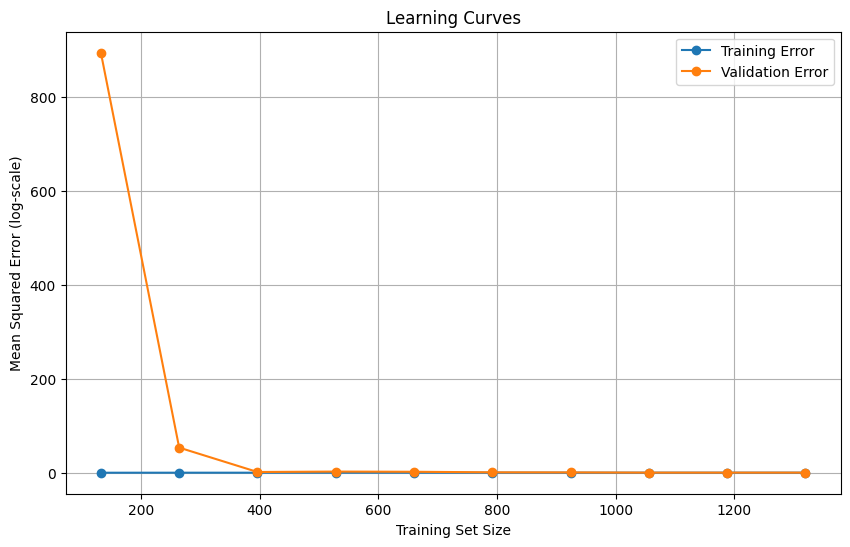

In [88]:
# Fit and evaluate the model
fit_log_results(poly_model, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(poly_model, X_log, y_log, cv=kf)
# learn curves
learn_curves(poly_model, X_log, y_log)

This Polynomial Regression result shows Low training RMSE (0.1419) but higher test RMSE (0.2394), indicating some overfitting. Moderate R² of 0.5074 suggests reasonable fit but less generalization. Cross-validation results show a drop in performance (R²: 0.4309), confirming overfitting. Training error curve drops quickly, validation error decreases but remains higher.

Model fits training data well but struggles to generalize, indicating moderate overfitting.

**XGBoost Model**

Train RMSE (log-scale): 0.0342
Test RMSE (log-scale): 0.1340
Train MAE: 0.1399, Test MAE: 0.2759
R² Score: 0.7244
------------------------------------
Cross-validated RMSE (log-scale): 0.1336
Cross-validated MAE: 0.2638
Cross-validated R² Score: 0.7162
------------------------------------


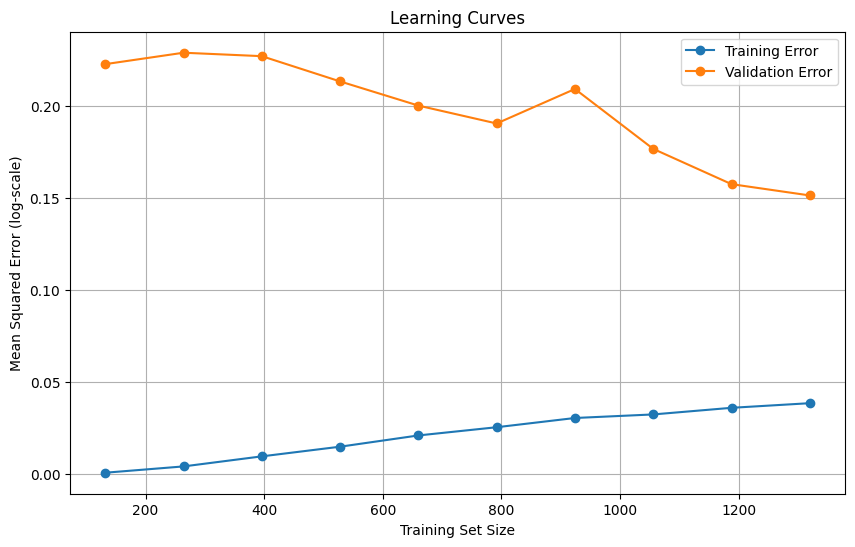

In [89]:
# model pipeline
xgb_model_log = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5))
])

# Fit and evaluate the model
fit_log_results(xgb_model_log, X_train_log, X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(xgb_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(xgb_model_log, X_log, y_log)

                        Feature  Importance
4                  accommodates    0.586850
6                      bedrooms    0.118606
10  neighbourhood_cleansed_freq    0.052885
11           property_type_freq    0.045213
7                          beds    0.038917
3           host_listings_count    0.030560
1            host_response_rate    0.026430
5                     bathrooms    0.025670
9             number_of_reviews    0.022394
8                    avg_rating    0.021251


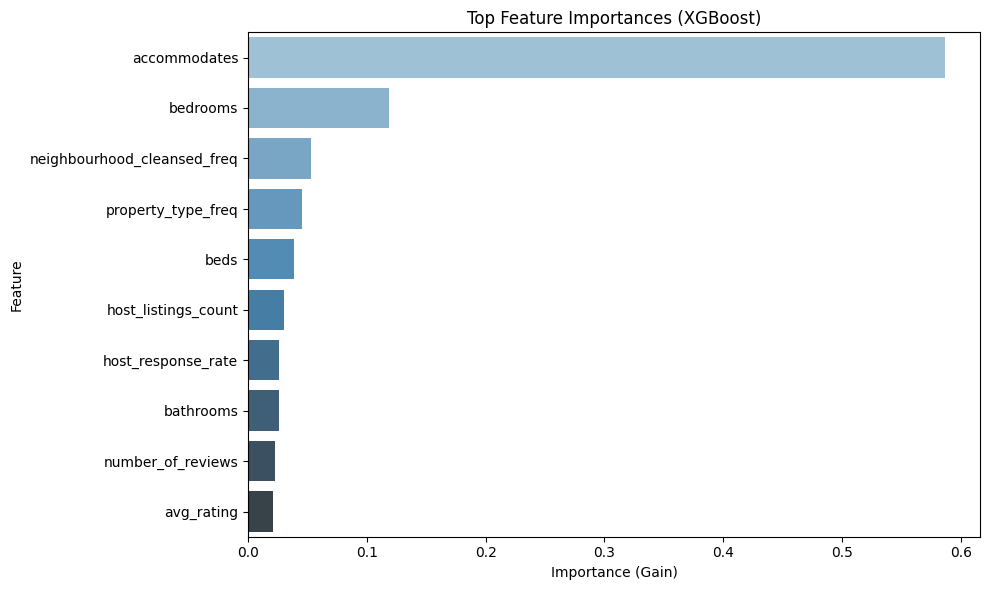

In [90]:
xgb_model_log.fit(X_train_log, y_train_log)

# Access the trained XGBoost model from the pipeline
xgb = xgb_model_log.named_steps['xgb']

# Get feature importances (default: 'gain')
importances = xgb.feature_importances_
feature_names = X_log.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Plot top N features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='Blues_d')
plt.title('Top Feature Importances (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This XGBoost model shows a Very low training error (RMSE 0.0342) and relatively low test error (RMSE 0.1340), indicating strong fit. High R² (0.7244) on test data shows good predictive power. Cross-validation metrics are consistent, confirming model generalizes well. The Learning curves show some gap but decreasing validation error, suggesting manageable complexity without severe overfitting. XGBoost model shows Strong, well-generalizing model with good accuracy and robustness.

Featrue importance from XGBoost model

 Feature importance in XGBoost is measured by gain, indicating the average improvement in model accuracy brought by a feature when used in splits. accommodates is the most impactful feature, contributing the highest gain, showing that the number of guests a listing can host plays a crucial role in price prediction. bedrooms also has a notable impact, followed by neighbourhood_cleansed_freq and property_type_freq, which reflect location and property type relevance. Features like beds, host_listings_count, and host_response_rate provide smaller contributions. avg_rating and number_of_reviews are the least important, suggesting limited influence on pricing. XGBoost’s ability to handle non-linear relationships and interactions makes it a powerful model, and its feature importance results support more targeted feature selection and interpretation of pricing dynamics.

**LightGBM Model**

Train RMSE (log-scale): 0.0320
Test RMSE (log-scale): 0.1282
Train MAE: 0.1303, Test MAE: 0.2718
R² Score: 0.7362
------------------------------------
Cross-validated RMSE (log-scale): 0.1343
Cross-validated MAE: 0.2665
Cross-validated R² Score: 0.7148
------------------------------------


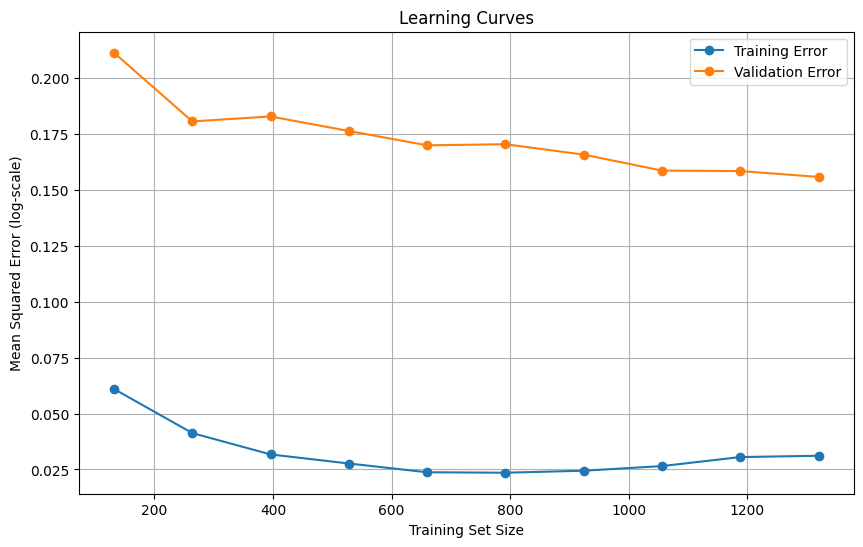

In [91]:
lgb_model_log = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', lgb.LGBMRegressor(objective='regression', verbose=-1))
])

fit_log_results(lgb_model_log, X_train_log,  X_test_log, y_train_log, y_test_log)
# cross-validate the pipeline
cross_validate_log_results(lgb_model_log, X_log, y_log, cv=kf)
# learn curves
learn_curves(lgb_model_log, X_log, y_log)

                        Feature  Importance
8                    avg_rating         582
0                       host_id         581
9             number_of_reviews         556
3           host_listings_count         297
11           property_type_freq         265
1            host_response_rate         144
5                     bathrooms         140
4                  accommodates         135
10  neighbourhood_cleansed_freq         105
6                      bedrooms         105


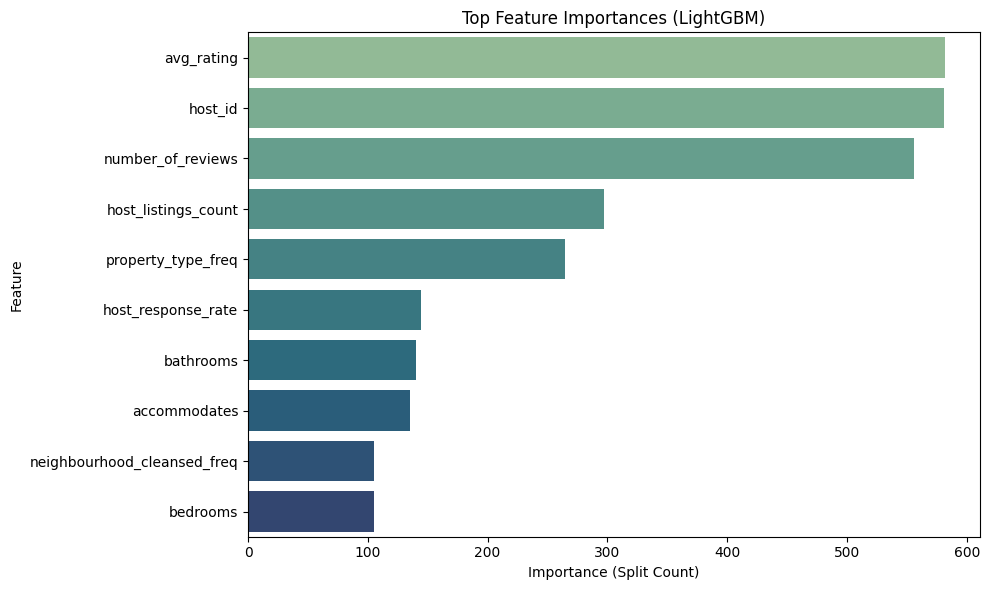

In [92]:
lgb_model_log.fit(X_train_log, y_train_log)

import pandas as pd

# Get the trained LightGBM model from the pipeline
lgb_model = lgb_model_log.named_steps['lgb']

# Extract feature importances
importances = lgb_model.feature_importances_
feature_names = X_log.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', palette='crest')
plt.title('Top Feature Importances (LightGBM)')
plt.xlabel('Importance (Split Count)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This LightGBM model shows Low training error (RMSE 0.0313) and low test error (RMSE 0.1282), indicating a strong fit. High R² on test (0.7362) and cross-validation (0.716) indicates good generalization and predictive power. Learning curves suggest some gap between training and validation error but no severe overfitting. Consistent cross-validation results confirm model robustness.

LightGBM performs very well, slightly better than XGBoost here, with strong accuracy and good generalization.

**Neural Network Model**

In [93]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

# Define neural network model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', kernel_initializer='glorot_uniform', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_initializer=HeNormal()),
        Dense(1)  # Regression output layer
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='mse'
    )
    return model

# Initialize and train the model
input_dim = X_train_scaled.shape[1]
nn_model = create_nn_model(input_dim)

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with scaled data
history = nn_model.fit(
    X_train_scaled, y_train_log,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions using scaled data
y_train_pred = nn_model.predict(X_train_scaled).flatten()
y_test_pred = nn_model.predict(X_test_scaled).flatten()

# Evaluation
train_rmse = np.exp(mean_squared_error(y_train_log, y_train_pred))-1
test_rmse = np.exp(mean_squared_error(y_test_log, y_test_pred))-1
train_mae = mean_absolute_error(y_train_log, y_train_pred)
test_mae = mean_absolute_error(y_test_log, y_test_pred)
train_r2 = r2_score(y_train_log, y_train_pred)
test_r2 = r2_score(y_test_log, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.2f}")

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.9373 - val_loss: 2.0211
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9559 - val_loss: 1.2505
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1804 - val_loss: 1.1136
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6989 - val_loss: 0.9646
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4051 - val_loss: 1.1851
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3603 - val_loss: 0.5649
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0867 - val_loss: 0.7186
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9051 - val_loss: 1.1364
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7382 - val_loss: 0.7361
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8119 - val_loss: 0.6581
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7869 - val_loss: 0.5672
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

The Neural Network model shows Good fit with close train and test RMSE (0.15 vs 0.17) and MAE (0.27 vs 0.31), indicating low overfitting. R² of 0.67 suggests strong predictive performance.

A well-balanced model with solid accuracy and generalization.

**Save Best Model**

While Random Forest and XGBoost also showed strong performance, LightGBM had slightly better test error and R². LightGBM offers the best balance of accuracy, generalization, and efficiency, making it scientifically the most suitable model for deployment in this regression task. Because LightGBM is a gradient boosting framework that builds ensembles of decision trees sequentially, correcting previous errors. This leads to highly accurate, robust models that capture complex nonlinear relationships in the data. it is also good in Handling of Large Feature Spaces, Regularization & Flexibility i.e It supports various regularization techniques (e.g., feature fraction, bagging) that help avoid overfitting and improve generalization, evident in the tight train-test error gap.

In [94]:
# Fit model
#lgb_model_log.fit(X_train_log, y_train_log)

# Save model to a file
#joblib.dump(lgb_model_log, 'lgb_model_log.pkl')

#print("Model saved as lgb_model_log.pkl")

**Suggest Price to Property Owners**

In [95]:
# Load the saved model from the pickle file
saved_model = joblib.load('lgb_model_log.pkl')

# Prompt the user to enter the property details
host_id = input("Enter the host ID (e.g. 1952066, 59072 etc): ")
host_response_rate = float(input("Enter the host response rate (as a decimal): "))
host_is_superhost = input("Is the host a superhost? (yes/no): ")
host_listings_count = int(input("Enter the number of host listings: "))
accommodates = int(input("Enter the number of people the property can accommodate: "))
bathrooms = float(input("Enter the number of bathrooms: "))
bedrooms = float(input("Enter the number of bedrooms: "))
beds = float(input("Enter the number of beds: "))
avg_rating = float(input("Enter the average rating: "))
number_of_reviews = int(input("Enter the number of reviews: "))
neighbourhood_cleansed = input("Enter the neighbourhood: ")
property_type = input("Enter the property type (e.g., Entire home, Private room etc): ")

# Frequency encode the neighbourhood and property type
neighbourhood_cleansed_freq = dublin_aggregated_df[dublin_aggregated_df['neighbourhood_cleansed'] == neighbourhood_cleansed]['neighbourhood_cleansed_freq'].mean()
property_type_freq = dublin_aggregated_df[dublin_aggregated_df['property_type'] == property_type]['property_type_freq'].mean()

# Create a DataFrame with the property details
property_details = pd.DataFrame({
    'host_id': [host_id],
    'host_response_rate': [host_response_rate],
    'host_is_superhost': [1 if host_is_superhost.lower() == 'yes' else 0],
    'host_listings_count': [host_listings_count],
    'accommodates': [accommodates],
    'bathrooms': [bathrooms],
    'bedrooms': [bedrooms],
    'beds': [beds],
    'avg_rating': [avg_rating],
    'number_of_reviews': [number_of_reviews],
    'neighbourhood_cleansed_freq': [neighbourhood_cleansed_freq],
    'property_type_freq': [property_type_freq]
})

# Make a prediction using the saved model
log_price = saved_model.predict(property_details)
price = np.exp(log_price[0])

# Print the predicted price
print(f"The predicted price for the property is GBP {price:.2f}")

Enter the host ID (e.g. 1952066, 59072 etc): 790601
Enter the host response rate (as a decimal): 0.75
Is the host a superhost? (yes/no): no
Enter the number of host listings: 4
Enter the number of people the property can accommodate: 5
Enter the number of bathrooms: 1
Enter the number of bedrooms: 1
Enter the number of beds: 3
Enter the average rating: 4.691429
Enter the number of reviews: 7225
Enter the neighbourhood: Dublin City
Enter the property type (e.g., Entire home, Private room etc): Entire rental unit
The predicted price for the property is GBP 227.38
